In [25]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as P
import tensorflow.keras as  keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import normalize
import scipy.stats as ss
import pickle
import math
import os
import shap
from sklearn.metrics import *

from time import time

In [12]:
from tensorflow.keras.layers import LeakyReLU, ThresholdedReLU

In [4]:
activations.LeakyReLU

AttributeError: module 'tensorflow_core.keras.activations' has no attribute 'LeakyReLU'

In [26]:
df = pd.read_csv('data_GE.csv')
df.set_index('datum', inplace = True)
df.index = pd.to_datetime(df.index)
df.sort_index()
df

,cases_FR,diff_cases_FR,diff_2_cases_FR,cases_GE,diff_cases_GE,diff_2_cases_GE,cases_GR,diff_cases_GR,diff_2_cases_GR,cases_JU,...,test_TI,diff_test_TI,diff_2_test_TI,test_VD,diff_test_VD,diff_2_test_VD,test_VS,diff_test_VS,diff_2_test_VS,vac_all
datum,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.285714,0.000000,-0.285714,1.428571,0.142857,0.142857,1.285714,0.142857,-0.142857,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-02,0.285714,0.000000,0.000000,1.714286,0.285714,0.142857,1.285714,0.000000,-0.142857,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-03,0.714286,0.428571,0.428571,1.714286,0.000000,-0.285714,1.428571,0.142857,0.142857,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-04,1.000000,0.285714,-0.142857,1.714286,0.000000,0.000000,1.142857,-0.285714,-0.428571,0.571429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-05,1.142857,0.142857,-0.142857,1.857143,0.142857,0.142857,1.285714,0.142857,0.428571,0.571429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-09,1352.000000,-4.571429,-70.428571,2443.428571,-1.142857,-119.857143,1013.285714,-13.714286,-48.571429,382.000000,...,3794.285714,61.000000,-192.714286,8843.142857,111.857143,-507.428571,4036.571429,53.571429,-170.285714,162.535714
2022-01-10,1363.000000,11.000000,15.571429,2520.571429,77.142857,78.285714,975.285714,-38.000000,-24.285714,348.571429,...,3848.000000,53.714286,-7.285714,9018.714286,175.571429,63.714286,4030.142857,-6.428571,-60.000000,163.337143
2022-01-11,1334.857143,-28.142857,-39.142857,2515.857143,-4.714286,-81.857143,927.857143,-47.428571,-9.428571,319.000000,...,3851.714286,3.714286,-50.000000,9028.142857,9.428571,-166.142857,3984.571429,-45.571429,-39.142857,164.125714


In [27]:
data_n = df.values

target_col = df.columns.get_loc("hosp_GE")

data_n

array([[ 2.85714286e-01,  0.00000000e+00, -2.85714286e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.85714286e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.14285714e-01,  4.28571429e-01,  4.28571429e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.33485714e+03, -2.81428571e+01, -3.91428571e+01, ...,
        -4.55714286e+01, -3.91428571e+01,  1.64125714e+02],
       [ 1.28885714e+03, -4.60000000e+01, -1.78571429e+01, ...,
        -8.00000000e+01, -3.44285714e+01,  1.64895714e+02],
       [ 1.19871429e+03, -9.01428571e+01, -4.41428571e+01, ...,
        -1.51142857e+02, -7.11428571e+01,  1.65647143e+02]])

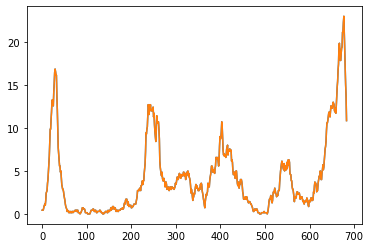

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(df.hosp_GE.values)
ax.plot(data_n[:, target_col])

plt.show()

In [54]:
print(data_n.shape[0]*0.75)

513.0


In [30]:
X_train = data_n[:547]

mean  = X_train.mean(axis=0)

data_n -= mean

std = X_train.std(axis=0)

data_n /= std


In [31]:
def split_data(df, look_back=12, predict_n=5, Y_column=0):
    """
    Split the data into training and test sets
    Keras expects the input tensor to have a shape of (nb_samples, timesteps, features).
    :param df: Pandas dataframe with the data.
    :param look_back: Number of weeks to look back before predicting
    :param ratio: fraction of total samples to use for training
    :param predict_n: number of weeks to predict
    :param Y_column: Column to predict
    :return:
    """
    #df = np.nan_to_num(df.values).astype("float64")
    # n_ts is the number of training samples also number of training sets
    # since windows have an overlap of n-1
    n_ts = df.shape[0] - look_back - predict_n + 1
    # data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    data = np.empty((n_ts, look_back + predict_n, df.shape[1]))
    for i in range(n_ts):  # - predict_):
        #         print(i, df[i: look_back+i+predict_n,0])
        data[i, :, :] = df[i: look_back + i + predict_n, :]
    # train_size = int(n_ts * ratio)

    # We are predicting only column 0
    X = data[:, :look_back, :]
    Y = data[:, look_back:, Y_column]


    return X, Y

In [32]:
X, Y = split_data(data_n, look_back = 14, predict_n = 14, Y_column = target_col)

In [55]:
X_train, Y_train = X[:479], Y[:479] 
X_val, Y_val = X[479:547], Y[479:547]
X_test, Y_test = X[547:], Y[547:]

In [40]:
val_steps = 547 - 479 - 14 
test_steps = len(X) - 547 - 14

In [13]:
def build_model(hidden, features, predict_n, look_back=10, batch_size=1):
    """
    Builds and returns the LSTM model with the parameters given
    :param hidden: number of hidden nodes
    :param features: number of variables in the example table
    :param look_back: Number of time-steps to look back before predicting
    :param batch_size: batch size for batch training
    :return:
    """
    inp = keras.Input(
        shape=(look_back, features),
        # batch_shape=(batch_size, look_back, features)
    )
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
        # activation='relu',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(inp, training=True)
    x = Dropout(0.2)(x, training=True)
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
        return_sequences=True,
         activation='LeakyReLU',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(x, training=True)
    x = Dropout(0.2)(x, training=True)
    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful=False,
        batch_input_shape=(batch_size, look_back, features),
         activation='LeakyReLU',
        dropout=0.1,
        recurrent_dropout=0.1,
        implementation=2,
        unit_forget_bias=True,
    )(x, training=True)
    x = Dropout(0.2)(x, training=True)
    out = Dense(
        predict_n,
        activation="LeakyReLU",
        kernel_initializer="random_uniform",
        bias_initializer="zeros",
    )(x)
    model = keras.Model(inp, out)

    start = time()
    model.compile(loss="msle", optimizer="adam", metrics=["accuracy", "mape", "mse"])
    print("Compilation Time : ", time() - start)
    plot_model(model, to_file="LSTM_model.png")
    print(model.summary())
    return model

In [14]:
model =  build_model(4, features = 73, predict_n=14, look_back=14, batch_size=1)

model

NameError: name 'keras' is not defined

In [56]:
%%time
hist = model.fit(
        X_train,
        Y_train,
        batch_size=1,
        epochs=50,
        validation_split=0.15,
        verbose=1)

Train on 407 samples, validate on 72 samples
Epoch 1/50
391/407 [===========================>..] - ETA: 1s - loss: 0.1904 - accuracy: 0.1282 - mape: 137.1897 - mse: 1.0686

KeyboardInterrupt: 